# Problem Statement: Green CVRP with ε-Constraint Method

Using  Gurobi, I create a small instance of the **Green Capacitated Vehicle Routing Problem (CVRP)** on a single depot (node 0) and 8 customers (nodes 1–8).  Each customer $i$ has demand $d_i$ (kg), and each vehicle has capacity $Q$ (kg).  We have at most $k$ identical vehicles.

Our **decision variables** are:
- $x_{ij}\in\{0,1\}$: whether a vehicle travels directly from node $i$ to node $j$.
- $q_{ij}\ge0$: the load (kg) carried on arc $(i,j)$.

### Constraints

1. **Visit constraints**  
   Ensure each customer is entered exactly once and left exactly once:
   $$\sum_{j\neq i}x_{ij}=1 \;\forall i\in C,\quad
     \sum_{i\neq j}x_{ij}=1 \;\forall j\in C.$$

2. **Fleet size**  
   The number of tours leaving depot equals the number returning, and is at most $k$:
   $$\sum_{j\in C}x_{0j} = \sum_{i\in C}x_{i0} \le k.$$

3. **Load conservation**  
   At each customer $h$, incoming load minus outgoing load equals demand:
   $$\sum_{i\neq h}q_{ih} - \sum_{j\neq h}q_{hj} = d_h.$$

4. **Capacity coupling**  
   If arc $(i,j)$ is used then its load cannot exceed vehicle capacity:
   $$0\le q_{ij} \le Q\,x_{ij}.$$

5. **Depot balances**  
   All demand must be loaded at the depot and vehicles return empty:
   $$\sum_{j\in C}q_{0j} = \sum_{h\in C}d_h,\quad
     \sum_{i\in C}q_{i0} = 0.$$

---

### Two Conflicting Objectives

- **Travel cost** $W_1(x)$ (EUR)

- **CO₂ emissions** $W_2(x)$ (kg)

---

### ε-Constraint Pareto Sweep

Rather than collapse both into a single weighted sum, we generate a **Pareto frontier** of truly nondominated trade-offs by:

1. **Anchor 1**: solve `build('W1')` → $\min W_1$ (pure travel cost).
2. **Anchor 2**: solve `build('CO2')` → $\min W_2$ (pure emissions).
3. **Sweep**: for a grid of CO₂‐caps $\varepsilon$ from $W_2^{\min}$ up to a relaxed upper bound,
   solve
   $$
     \min_{x}\;W_1(x)
     \quad\text{s.t.}\quad W_2(x)\le\varepsilon,
   $$
   and record each distinct $(W_1,W_2)$ pair.

This produces a **list of $(\text{travel cost €},\,\text{kg CO₂})$** points that lie on the Pareto frontier for our specific 8-customer instance. Plotting these points (CO₂ on the $x$-axis, travel cost € on the $y$-axis) reveals the shape of the cost–emissions trade-off.


Ahmed Elhefnawy.

# Importing the required libraries

In [315]:
import math, gurobipy as gp
from gurobipy import GRB

- `math` for calculating Euclidean distance.
- `gurobipy` Gurobi’s Python API.
- `GRB` is a class that serves as a namespace for constants used within gurobipy:
  `GRB.BINARY` is used to specify a binary variable (either 0 or 1), while `GRB.MINIMIZE` is used to define the objective function as a minimization problem.
  See the documentation: https://docs.gurobi.com/projects/optimizer/en/current/reference/python/grb.html 

# Sets

In [319]:
coords = {0:(0,0), 
          1:(7,1), 
          2:(10,-4), 
          3:(-6,5),
          4:(-9,-5), 
          5:(4,9), 
          6:(-2,-8), 
          7:(8,7), 
          8:(-8,1)}

C, N        = list(range(1,9)), list(range(9))          # 8 customers

$C = {8}$ (8 customers).

$N = {0} ∪ C$ (all nodes: depot 0 & customers).

We have 9 nodes in total.

The coordinates $(x,y)$ of each node in a Euclidean plane are:

| Node | \(x\) | \(y\) |
|:----:|:----:|:----:|
| 0    |   0  |   0   |
| 1    |   7  |   1   |
| 2    |  10  |  –4   |
| 3    |  –6  |   5   |
| 4    |  –9  |  –5   |
| 5    |   4  |   9   |
| 6    |  –2  |  –8   |
| 7    |   8  |   7   |
| 8    |  –8  |   1   |

Those nine pairs are just 2-D Cartesian “locations” for the depot (node 0) and the eight customers (nodes 1–8). They can be considered as an $(x,y)$ map in kilometres—e.g. node 1 sits at (7 km east, 1 km north) of the origin, node 3 at (–6 km east, 5 km north), and so on.

$A = \{(i,j) \in N \times N \mid i \ne j\}$ : directed arcs between distinct nodes. Since $|N|$ = 9, there are
$$
|A| = 9 \cdot (9-1) = 72
$$ 


# Parameters

## Distance Matrix

I then compute the straight-line (Euclidean) distance between any two points by $D_{ij} = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}$, rounded to two decimal points:  

| Node |   0   |   1   |   2   |   3   |   4   |   5   |   6   |   7   |   8   |
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| **0** | 0.00 | 7.07 | 10.77 | 7.81 | 10.30 | 9.85 | 8.25 | 10.63 | 8.06 |
| **1** | 7.07 | 0.00 | 5.83  | 13.60 | 17.09 | 8.54 | 12.73 | 6.08 | 15.00 |
| **2** |10.77 | 5.83 | 0.00  | 18.36 | 19.03 | 14.32| 12.65 |11.18 | 18.68 |
| **3** | 7.81 |13.60 |18.36  | 0.00  | 10.44 | 10.77| 13.60 |14.14 | 4.47 |
| **4** |10.30 |17.09 |19.03  | 10.44 | 0.00  | 19.10| 7.62 |20.81 | 6.08 |
| **5** | 9.85 | 8.54 |14.32  | 10.77 | 19.10 | 0.00 | 18.03 | 4.47 | 14.42 |
| **6** | 8.25 |12.73 |12.65  | 13.60 | 7.62  | 18.03| 0.00 |18.03 | 10.82 |
| **7** |10.63 | 6.08 |11.18  | 14.14 | 20.81 | 4.47 | 18.03 | 0.00 | 17.09 |
| **8** | 8.06 |15.00 |18.68  | 4.47  | 6.08  | 14.42| 10.82 |17.09 | 0.00 |

In Python:

In [325]:
D = {(i,j): math.hypot(coords[i][0]-coords[j][0],
                       coords[i][1]-coords[j][1])
     for i in N for j in N if i!=j}                     # km

## Demand per customer

| Customer                  | Demand (kg) |
|:--------------------------|------------:|
| 1                         |       6 000 |
| 2                         |       7 000 |
| 3                         |       5 000 |
| 4                         |       9 000 |
| 5                         |       4 000 |
| 6                         |       6 000 |
| 7                         |       8 000 |
| 8                         |       5 000 |
| **Total demand**          |      50 000 |


In [328]:
dem         = {1:6000, 
               2:7000, 
               3:5000, 
               4:9000,
               5:4000, 
               6:6000, 
               7:8000, 
               8:5000}

## Vehicle

| Parameter                        |  Value |
| :---------------------------- | :----: |
| **Number of vehicles**        |    5   |
| **Capacity per vehicle (kg)** | 24 000 |
| **Total fleet capacity (kg)** | 120 000 |


In [331]:
capacity    = 24_000                                    # kg
max_veh     = 5

## Speed

- local / short arcs ≤ 8 km → 60 km/h
- long / highway arcs → 90 km/h

In [334]:
speed = {a: 60 if D[a] <= 8.0 else 90 for a in D}       # km/h

## Monetary travel cost ($c_{ij}$)

I assume that it costs €50 for each hour on the road (driver's wage, tolls, maintenance, etc.)

For each arc $a = {i, j}$, we know the distance $D_a$ (in km) and the average speed $v_a$ (in km/h), so the time spent on arc $a$ is $D_a / v_a$ hours. 

Therefore, $c_{ij} = 50 \cdot \frac{D_a}{v_a}$ 

In Python:

In [337]:
cost_per_hour = 50.0                                    # EUR / h
c = {a: cost_per_hour * D[a] / speed[a] for a in D}     # EUR

# Constants

| symbol      | meaning (unit)                       | value                      |
| ----------- | ------------------------------------ | -------------------------- |
| `alpha_rr`  | rolling-resistance kWh / kg km       | 4.77 × 10⁻⁵                |
| `beta_aero` | aero coefficient kWh / km (km h⁻¹)⁻² | 1.929 × 10⁻⁴               |
| `w_empty`   | empty truck mass (kg)                | 5 000                      |
| `pi_fuel`   | diesel price €/kWh                   | 0.20                       |
| `beta_co2`  | CO₂ price €/kg                       | 0.05                       |
| `kappa`     | CO₂ factor kg/kWh                    | 0.268                      |
| `gamma`     | fuel + carbon price €/kWh            | `pi_fuel + beta_co2*kappa` |


In [340]:
alpha_rr  = 4.77e-5      # kWh / (kg·km)
beta_aero = 1.929e-4     # kWh / km / (km/h)^2
w_empty   = 5000         # kg
pi_fuel   = 0.20         # EUR / kWh
beta_co2  = 0.05         # EUR / kg CO2
kappa     = 0.268        # kg CO2 / kWh
gamma     = pi_fuel + beta_co2 * kappa

# Decision variables

| Symbol | Type & bounds                | How many?    | Interpretation |
|--------|------------------------------|------------------|----------------|
| $x_{ij}$ | binary, $x_{ij}\in\{0,1\}$  | $9\times8-9=72$     | 1 ⇔ the truck **drives directly** from node $i$ to node $j$ (directed arc). |
| $q_{ij}$ | continuous, $0 \le q_{ij} \le Q\,x_{ij}$ | 72               | Payload (kg) **on board immediately after leaving** node $i$ bound for $j$. Coupled to $x_{ij}$: if the arc is unused ($x_{ij}=0$) then $q_{ij}=0$. |

> With 72 binary $x_{ij}$ and 72 continuous $q_{ij}$ variables, the model has  
> **144 decision variables** in total for this specific instance.


# The Model in Gurobi

In [344]:
def build(mode: str, eps: float | None = None):
    """
    mode ∈ {'W1', 'CO2', 'eps'}

        'W1'  – minimise driver/toll cost  (W1)
        'CO2' – minimise total emissions   (CO2)
        'eps' – ε-constraint: minimise W1  subject to  CO2 ≤ eps

    returns
        m        – gurobipy.Model
        W1       – Expr: driver/toll €  (objective or report)
        fuel_EUR – Expr: fuel+carbon €  (= γ · energy)
        CO2kg    – Expr: kg of CO2
        x        – dict of x[i,j] binary vars
    """

    # ------------------------------------------------------------------
    # 0. Model shell + decision variables
    # ------------------------------------------------------------------
    m = gp.Model()                     # new empty model
    m.Params.OutputFlag = 0            # silence solver log

    # x[i,j] = 1 if arc (i→j) is used
    x = m.addVars(D.keys(), vtype=GRB.BINARY, name="x")
    x._model = m 

    # q[i,j] = load (kg) carried on that arc
    q = m.addVars(D.keys(), lb=0.0, name="q")

    # ------------------------------------------------------------------
    # 1. VISIT CONSTRAINTS  (every customer exactly once)
    # ------------------------------------------------------------------
    # out-degree of each customer i ∈ C must be 1
    m.addConstrs(
        gp.quicksum(x[i, j] for j in N if j != i) == 1
        for i in C
    )
    # in-degree of each customer j ∈ C must be 1
    m.addConstrs(
        gp.quicksum(x[i, j] for i in N if i != j) == 1
        for j in C
    )

    # ------------------------------------------------------------------
    # 2. VEHICLE COUNT  (departures = returns ≤ max_veh)
    # ------------------------------------------------------------------
    dep = gp.quicksum(x[0, j] for j in C)   # arcs that leave depot
    ret = gp.quicksum(x[i, 0] for i in C)   # arcs that return to depot
    m.addConstr(dep == ret)                 # same number of tours close
    m.addConstr(dep <= max_veh)             # fleet size cap

    # ------------------------------------------------------------------
    # 3. LOAD CONSERVATION  (Flow of kg at each customer)
    # ------------------------------------------------------------------
    m.addConstrs(
        gp.quicksum(q[i, h] for i in N if i != h)     # kg entering h
        -
        gp.quicksum(q[h, j] for j in N if j != h)     # kg leaving h
        ==
        dem[h]                                        # demand of h
        for h in C
    )

    # ------------------------------------------------------------------
    # 4. CAPACITY COUPLING  (link q and x)
    # ------------------------------------------------------------------
    # If arc (i,j) is not used (x=0) then q must be 0; otherwise q ≤ vehicle capacity.
    m.addConstrs(
        q[a] <= capacity * x[a]
        for a in D
    )

    # ------------------------------------------------------------------
    # 5. DEPOT BALANCES
    # ------------------------------------------------------------------
    # (a) amount loaded into trucks at depot = total demand
    m.addConstr(
        gp.quicksum(q[0, j] for j in C) == sum(dem.values())
    )
    # (b) trucks must return empty
    m.addConstr(
        gp.quicksum(q[i, 0] for i in C) == 0
    )

    # ------------------------------------------------------------------
    # 6. OBJECTIVE BUILDING BLOCKS
    # ------------------------------------------------------------------
    # ---- 6.1  Driver/toll cost  W1 (€)  ------------------------------
    # c[a] already equals  (€/h) · (dist/speed)  for arc a
    W1 = gp.quicksum(c[a] * x[a] for a in D)

    # ---- 6.2  Energy consumption  (kWh)  ----------------------------
    #   α_rr  · (payload + empty mass) · distance      (rolling resistance)
    # + β_aero · v² · distance                         (aerodynamic drag)
    energy = gp.quicksum(
        (
            alpha_rr * (q[a] + w_empty * x[a]) +
            beta_aero * (speed[a] ** 2) * x[a]
        ) * D[a]
        for a in D
    )

    # ---- 6.3  Convert energy to € and to kg CO2 ----------------------
    fuel_EUR = gamma * energy       # γ = π_fuel  + β_CO2·κ
    CO2kg    = kappa * energy       # κ (kg CO2 per kWh)

    # ------------------------------------------------------------------
    # 7. CHOOSE OBJECTIVE ACCORDING TO `mode`
    # ------------------------------------------------------------------
    if mode == 'W1':
        # minimise travel cost only
        m.setObjective(W1, GRB.MINIMIZE)

    elif mode == 'CO2':
        # minimise emissions only
        m.setObjective(CO2kg, GRB.MINIMIZE)

    elif mode == 'eps':
        # ε-constraint:
        #   first, restrict CO2 to eps  (<= with tiny tolerance)
        m.addConstr(CO2kg <= eps + 1e-6)
        #   then minimise travel cost
        m.setObjective(W1, GRB.MINIMIZE)

    else:
        raise ValueError("mode must be 'W1', 'CO2', or 'eps'")

    # ------------------------------------------------------------------
    # 8. Return what the caller needs to solve or inspect the model
    # ------------------------------------------------------------------
    return m, W1, fuel_EUR, CO2kg, x


# ─────────────────────────────────────────────────────────────
#  routes(xvars)
#     • Returns a list of routes, each route being a list of tuples   (i , j , load_ij)      ← load after leaving node i
# ─────────────────────────────────────────────────────────────
def routes(xvars):
    # grab the model we attached in build()
    mdl = xvars._model

    # build a lookup of q-values
    q_lookup = {}
    for var in mdl.getVars():
        if var.VarName.startswith("q["):
            # parse "q[i,j]"
            key = tuple(int(k) for k in var.VarName[2:-1].split(','))
            q_lookup[key] = var.X

    # build successor list and load on arcs
    succ, load = {}, {}
    for (i, j), xvar in xvars.items():
        if xvar.X > 0.5:
            succ.setdefault(i, []).append(j)
            load[(i, j)] = q_lookup[(i, j)]

    # extract tours
    routes_out, seen = [], set()
    for j in succ.get(0, []):
        if j in seen: continue
        cur = 0
        route = []
        while True:
            nxt = succ[cur].pop()
            route.append((cur, nxt, load[(cur, nxt)]))
            cur = nxt
            seen.add(cur)
            if cur == 0:
                break
        routes_out.append(route)

    return routes_out


# ─────────────────────────────────────────────────────────────
#  show(label, W1, fuel, CO2, xvars)
#     • prints every arc as     i(load_ij kg) -> j(load_jk kg)
# ─────────────────────────────────────────────────────────────
def show(label, W1, fuel, CO2, xvars):
    print(f"\n{label}")
    print(f"  driver/toll  : {W1:8.2f} EUR")
    print(f"  fuel+carbon  : {fuel:8.2f} EUR")
    print(f"  total cost   : {W1 + fuel:8.2f} EUR")
    print(f"  emissions    : {CO2:8.2f} kg CO2")

    for route in routes(xvars):
        # each route is a list of (i, j, load_ij)
        # we print i(load_i) -> j(load_j) ...
        parts = []
        for (i, j, load_ij) in route:
            parts.append(f"{i}({load_ij:.0f}kg)")
        # ensure final depot is shown:
        parts.append("0(0kg)")
        print("   " + " -> ".join(parts))

# ──────────────────────────────────────────────────────────

if __name__ == "__main__":

    # ────────────────────────────────────────────────
    # (1)   Minimise W1  –  pure travel cost
    # ────────────────────────────────────────────────
    m1, W1min, fuel1, CO21, x1 = build('W1')   # build model
    m1.optimize()                              # let Gurobi solve it
    show(                                       # pretty-print results
        "Travel-cost optimum",
        W1min.getValue(),                      # EUR spent on driver time, etc.
        fuel1.getValue(),                      # EUR spent on fuel+CO2
        CO21.getValue(),                       # kg CO2 emitted
        x1                                     # arc variables (for routes)
    )

    # ────────────────────────────────────────────────
    # (2)   Minimise CO2 only – environmental extreme
    # ────────────────────────────────────────────────
    m2, W1c2, fuel2, CO2min, x2 = build('CO2')
    m2.optimize()
    show(
        "CO2-only optimum",
        W1c2.getValue(),
        fuel2.getValue(),
        CO2min.getValue(),
        x2
    )

    # ────────────────────────────────────────────────
    # (3)   ε-constraint sweep
    #       ▸ Keep tightening / loosening a CO2 cap
    #       ▸ For each cap, minimise W1
    #       ▸ Collect distinct (W1 , CO2) pairs = Pareto points
    # ────────────────────────────────────────────────
    eps_step = 0.50            # granularity of the sweep (smaller = more points)

    # Lower bound = best possible CO2 from step (2)
    eps_lo = round(CO2min.getValue(), 2)

    # Upper bound = CO2 level at the driver-optimal solution + 8 kg buffer
    eps_hi = round(CO21.getValue() + 8.0, 2)

    pareto = []                # list of non-dominated (W1 , CO2) pairs
    eps    = eps_lo            # current ε value (kg CO2)

    while eps <= eps_hi + 1e-9:                     # sweep inclusive of eps_hi
        m, W1, fuel, CO2, _ = build('eps', eps)     # build ε-constrained model
        m.optimize()

        if m.status == GRB.OPTIMAL:                 # ignore infeasible caps
            point = (round(W1.getValue(), 2),
                     round(CO2.getValue(), 2))

            # Store the pair only if it differs from the last one recorded.
            # This removes near-duplicates due to numeric rounding.
            if not pareto or point != pareto[-1]:
                pareto.append(point)

        eps += eps_step                             # move to the next CO2 cap

    # ────────────────────────────────────────────────
    #  Print the Pareto front we found
    # ────────────────────────────────────────────────
    print("\nPareto front  (travel EUR  vs  kg CO2)")
    for w1, kg in pareto:
        print(f"  {w1:8.2f} EUR   {kg:8.2f} kg CO2")



Travel-cost optimum
  driver/toll  :    56.95 EUR
  fuel+carbon  :    39.18 EUR
  total cost   :    96.13 EUR
  emissions    :    49.20 kg CO2
   0(6000kg) -> 6(0kg) -> 0(0kg)
   0(23000kg) -> 4(14000kg) -> 8(9000kg) -> 3(4000kg) -> 5(0kg) -> 0(0kg)

CO2-only optimum
  driver/toll  :    59.34 EUR
  fuel+carbon  :    33.56 EUR
  total cost   :    92.89 EUR
  emissions    :    42.14 kg CO2
   0(20000kg) -> 8(15000kg) -> 4(6000kg) -> 6(0kg) -> 0(0kg)
   0(17000kg) -> 7(9000kg) -> 5(5000kg) -> 3(0kg) -> 0(0kg)

Pareto front  (travel EUR  vs  kg CO2)
     59.34 EUR      42.49 kg CO2
     58.49 EUR      43.06 kg CO2
     58.49 EUR      43.96 kg CO2
     58.49 EUR      43.79 kg CO2
     58.49 EUR      43.96 kg CO2
     57.20 EUR      45.24 kg CO2
     57.20 EUR      45.78 kg CO2
     57.20 EUR      45.88 kg CO2
     57.20 EUR      45.78 kg CO2
     56.95 EUR      49.03 kg CO2
     56.95 EUR      49.20 kg CO2
     56.95 EUR      49.03 kg CO2
     56.95 EUR      49.20 kg CO2


## Pareto-optimal front 

|  Cost € |  CO₂ kg |
| :-----: | :-----: |
|  59.34  |  42.49  |
|  58.49  |  43.06  |
|  57.20  |  45.24  |
|  56.95  |  49.03  |


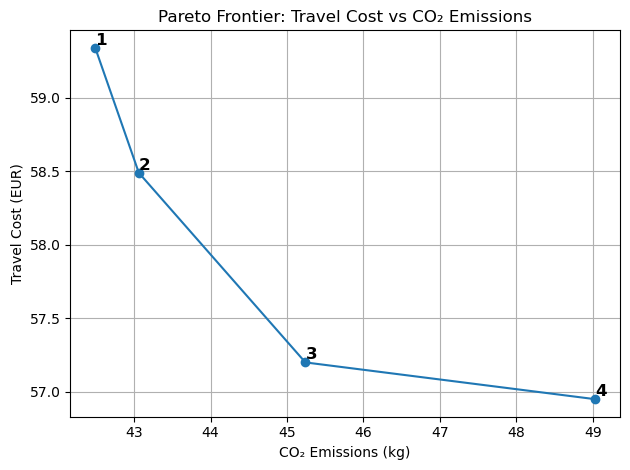

In [347]:
import matplotlib.pyplot as plt

pareto = [
    (59.34, 42.49),
    (58.49, 43.06),
    (57.20, 45.24),
    (56.95, 49.03),
]

co2 = [pt[1] for pt in pareto]
travel_cost = [pt[0] for pt in pareto]
indices = range(1, len(pareto) + 1)

fig, ax = plt.subplots()

# Plot the connecting curve
ax.plot(co2, travel_cost, marker='o')

# Annotate each point with its index
for idx, (x, y) in zip(indices, zip(co2, travel_cost)):
    ax.text(x, y, str(idx), fontsize=12, fontweight='bold',
            ha='left', va='bottom')

ax.set_xlabel('CO₂ Emissions (kg)')
ax.set_ylabel('Travel Cost (EUR)')
ax.set_title('Pareto Frontier: Travel Cost vs CO₂ Emissions')
ax.grid(True)

plt.tight_layout()
plt.show()


None of those four Pareto points dominates any other.  They’re all non-dominated:

**(1)** 59.34 € / 42.49 kg has the lowest emissions but highest cost.

**(2)** 58.49 € / 43.06 kg trades some emissions savings for cost.

**(3)** 57.20 € / 45.24 kg further lowers cost at the expense of more CO₂.

**(4)** 56.95 € / 49.03 kg is the cheapest but emits the most.

In every pair one solution is better on cost and the other is better on emissions, so no single “dominant” solution exists.


## 4 Pareto Frontier & ε-Constraint Method

### 4.1 Two Objectives  
For every **feasible** routing solution $x$, we compute $W_1 (x)$ and $W_2 (x)$.  

* **Travel cost** $W_1$ (€) 
* **Emissions** $W_2$ (kg CO₂)

---

### 4.2 Pareto Dominance  
Solution $x^{(a)}$ **dominates** $x^{(b)}$ if $W_1\!\bigl(x^{(a)}\bigr)\le W_1\!\bigl(x^{(b)}\bigr)$   and   $W_2\!\bigl(x^{(a)}\bigr)\le W_2\!\bigl(x^{(b)}\bigr)$, with at least one strict inequality. 

A solution is **Pareto-optimal** when no other feasible solution dominates it. The set of all Pareto-optimal points forms the **Pareto frontier**—each point is the best possible trade-off: improving one axis necessarily worsens the other.

---

### 4.3 ε-Constraint Method  

We want **all** efficient trade-offs between $W_1(x)$ and $W_2(x)$ on the **same** feasible set $\mathcal F$.

#### Parametric model  
Define, for any cap $\varepsilon$ (e.g., maximum amount of kg CO₂),

$$
\mathcal P(\varepsilon):
\quad
\begin{aligned}
\min_{x\in\mathcal F}\;& W_1(x)\\
\text{s.t.}\;& W_2(x)\le\varepsilon .
\end{aligned}
$$

We repeatedly solve $\mathcal P(\varepsilon)$ by sweeping $\varepsilon$ on a grid $\varepsilon_1<\varepsilon_2<\dots<\varepsilon_K$ to approximate the entire frontier. 

*Every optimal solution of $\mathcal P(\varepsilon)$ is Pareto-efficient.*

```text
# Logic behind ε–constraint sweep

ε_min  ←  best CO₂ value from “minimise‑CO₂” model        # left‑hand anchor
ε_max  ←  CO₂ of the “minimise‑cost” solution + buffer    # right‑hand limit
Δε     ←  chosen grid step (e.g. 0.50 kg)                 # resolution

Pareto ←  ∅                                                # list of (cost, CO₂)

for ε  in  { ε_min , ε_min+Δε , ε_min+2Δε , … , ε_max }:
    solve  𝒫(ε):     minimise   W₁   subject to   W₂ ≤ ε
    if 𝒫(ε) is feasible:
        point ← ( W₁*,  W₂* )        # optimal values returned by solver
        if point ≠ last stored one : # prevents numerical duplicates
            Pareto ← Pareto ∪ { point }

# after the loop  Pareto  holds a monotone sequence of non‑dominated
#                (travel‑cost €,  CO₂ kg)  pairs = sampled Pareto front
```

> *Interpretation* 
> – Each loop iteration fixes a CO₂ “budget” ε and asks, “What is the **cheapest** routing that stays within this budget?”
> – Moving ε from its tightest value up to a relaxed one traces the trade‑off curve between travel cost and emissions for **our specific instance**.

#### Sweep logic in the code  

```python
eps = eps_lo                # (= 42.14)
while eps <= eps_hi:        # (= 49.20 + 8 buffer)
    m = build('eps', eps)   # creates 𝒫(ε)
    m.optimize()            # ⇒ Pareto point (if feasible)
    store_if_new(...)
    eps += eps_step         # 0.50 kg
```
    
---

### 4.4 How the Code Implements This 

#### Single anchor points  
| call | mathematical programme | purpose |
|------|-------------------------|---------|
| `build('CO2')` | $\displaystyle\min_{x\in\mathcal F} W_2(x)$ | leftmost point (best possible $\text{CO}_2$). |
| `build('W1')`  | $\displaystyle\min_{x\in\mathcal F} W_1(x)$ | rightmost point (cheapest for the driver). |

These give the interval in which **every** Pareto point must lie:
$\,\bigl[\,W_2^{\min},\,W_2^{\max}\bigr]=[42.14,\;49.20]\,$ kg.

---

| Code line / block | Mathematical role |
|-------------------|-------------------|
| `build('eps', eps)` | Solves $\mathcal P(\varepsilon)$. |
| `eps_lo = round(CO2min,2)` | Starts sweep at smallest achievable emissions. |
| `eps_hi = round(CO21+8,2)` | Ends sweep just above emissions of the cost-optimal solution. |
| `eps_step` | Grid spacing $\Delta\varepsilon$ (smaller ⇒ denser sampling). |
| Duplicate filter | Stores a point only if $(W_1,W_2)$ differs from the previous one, removing near-duplicates. |

